In [57]:
import pandas as pd
from scipy import stats
import statsmodels.stats.multitest as smm
#from scipy.stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Описание данных:
userID: уникальный идентификатор пользователя
browser: браузер, который использовал userID
slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
n_clicks: количество кликов, которые пользоваль совершил за n_queries
n_queries: количество запросов, который совершил userID, пользуясь браузером browser
n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

In [3]:
raw = pd.read_csv("h:\\MyProj\\Courcera\\Ml-mipt\\course4\\week4AB\\ab_browser_test.csv", sep=",") 
raw.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
exp = raw.loc[raw['slot'] == 'exp']
control = raw.loc[raw['slot'] == 'control']
raw.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [5]:
round((exp['n_clicks'].sum()/control['n_clicks'].sum() - 1) * 100, 3)

1.614

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
exp_clicks = exp.n_clicks.values
ctl_clicks = control.n_clicks.values

In [9]:
np.random.seed(0)

exp_avg_clicks = list(map(np.average, get_bootstrap_samples(exp_clicks, 1000)))
ctl_avg_clicks = list(map(np.average, get_bootstrap_samples(ctl_clicks, 1000)))

print("95% confidence interval for the exp avg clicks:",  stat_intervals(exp_avg_clicks, 0.05))
print("95% confidence interval for the control avg clicks:",  stat_intervals(ctl_avg_clicks, 0.05))

95% confidence interval for the exp avg clicks: [11.5086867  11.66089388]
95% confidence interval for the control avg clicks: [11.20795095 11.35742732]


In [10]:
delta_avg_clicks = list(map(lambda x: x[0] - x[1], zip(exp_avg_clicks, ctl_avg_clicks)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_avg_clicks, 0.05))

95% confidence interval for the difference between medians [0.19172563 0.40475697]


In [11]:
exp_median_clicks = list(map(np.median, get_bootstrap_samples(exp_clicks, 1000)))
ctl_median_clicks = list(map(np.median, get_bootstrap_samples(ctl_clicks, 1000)))

print("95% confidence interval for the exp median clicks:",  stat_intervals(exp_median_clicks, 0.05))
print("95% confidence interval for the control median clicks:",  stat_intervals(ctl_median_clicks, 0.05))

95% confidence interval for the exp median clicks: [5. 5.]
95% confidence interval for the control median clicks: [4. 4.]


In [12]:
delta_median_clicks = list(map(lambda x: x[0] - x[1], zip(exp_median_clicks, ctl_median_clicks)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_clicks, 0.05))

95% confidence interval for the difference between medians [1. 1.]


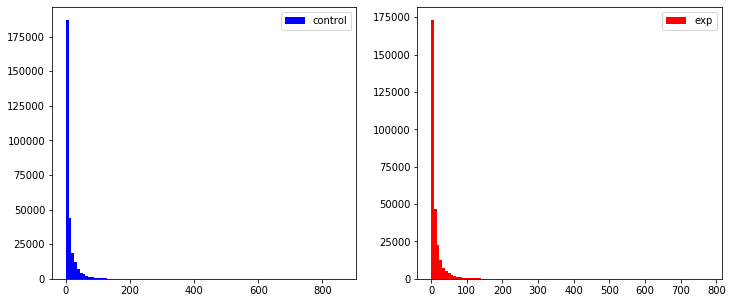

In [13]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(control.n_clicks, bins = 100, color = 'b' , label = 'control')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(exp.n_clicks, bins = 100, color = 'r' , label = 'exp')
pylab.legend()

pylab.show()

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$
, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

$\bar{X}$ — среднее значение в выборке — было распределено нормально $N(μ,σ^2/n)$

$(n/σ^2)*S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы $χ2(n−1)$ 

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

In [14]:
def sqv_summ(xx):
    avg = np.average(xx)
    summ = 0.0
    for aa in xx:
        summ = summ + ((avg - aa)*(avg - aa))
    return summ

In [15]:
np.random.seed(0)
n_boot_samples = 500

ctl_sqv_clicks = list(map(sqv_summ, get_bootstrap_samples(ctl_clicks, n_boot_samples)))
ctl_avg_clicks = list(map(np.average, get_bootstrap_samples(ctl_clicks, n_boot_samples)))

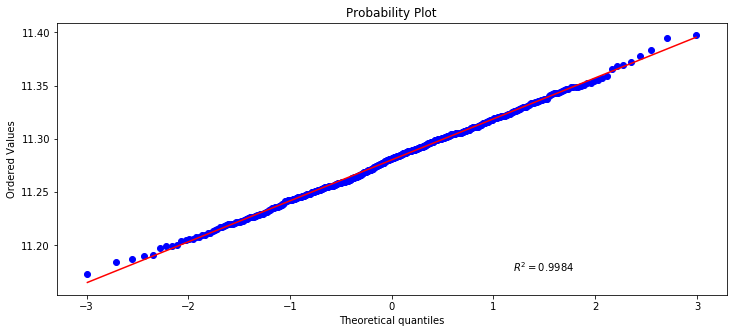

In [16]:
stats.probplot(ctl_avg_clicks, dist="norm", plot=pylab, rvalue=True)
plt.show()

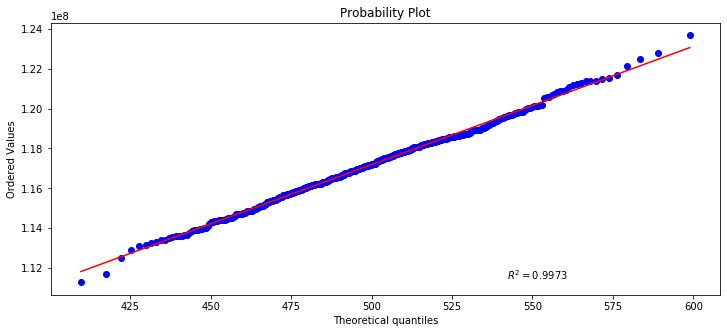

In [17]:
stats.probplot(ctl_sqv_clicks, dist="chi2", sparams=len(ctl_sqv_clicks)-1, plot=plt, rvalue=True)
plt.show()

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [21]:
exp_cbu = exp[['userID', 'n_clicks']].groupby('userID').sum()
ctl_cbu = control[['userID', 'n_clicks']].groupby('userID').sum()

In [27]:
ctl_cbu.head()

,n_clicks
userID,
6,12
8,4
10,22
15,2
23,3


In [28]:
exp_cbu.head()

,n_clicks
userID,
1,23
3,3
5,29
7,54
9,6


In [29]:
stats.mannwhitneyu(ctl_cbu['n_clicks'], exp_cbu['n_clicks'])

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [48]:
exp_br_cbu = exp[['browser', 'userID', 'n_clicks']].groupby(['browser', 'userID']).sum().reset_index()
ctl_br_cbu = control[['browser', 'userID', 'n_clicks']].groupby(['browser', 'userID']).sum().reset_index()
exp_br_cbu.head()
#exp[['browser', 'userID', 'n_clicks']].groupby(['userID', 'browser']).sum()

,browser,userID,n_clicks
0,Browser #14,13,2
1,Browser #14,30,4
2,Browser #14,33,22
3,Browser #14,45,5
4,Browser #14,83,0


In [58]:
data = []
for brname in raw['browser'].unique():
    stat, pvalue = stats.mannwhitneyu(exp_br_cbu.loc[exp_br_cbu['browser'] == brname]['n_clicks']
                       , ctl_br_cbu.loc[ctl_br_cbu['browser'] == brname]['n_clicks'])
    data.append([brname, pvalue])

data_frame = pd.DataFrame.from_records(data)
data_frame.columns = ['browser_name', 'pvalue']
reject, p_corrected, a1, a2 = smm.multipletests(data_frame.pvalue, 0.05, 'holm')
data_frame['pvalue_corrected'] = p_corrected
data_frame['reject'] = reject
print(data_frame)

  browser_name    pvalue  pvalue_corrected  reject
0   Browser #2  0.027244          0.136219   False
1   Browser #4  0.407606          0.815212   False
2  Browser #14  0.000000          0.000000    True
3  Browser #17  0.037401          0.149602   False
4  Browser #20  0.453667          0.815212   False
5  Browser #22  0.257406          0.772217   False
